# Team composed by:
- Agostara Nicolò
- Fratti Giorgio
- Fusillo Antonio
- Protti Edoardo

### THEORETICAL FRAMEWORK

The dataset contains ratings of items by users

For each couple $(u, i)$ of a user and a item, we consider
the discrete random variable $R(u, i)$ = "item i is relevant for user u"
$R(u, i) \in \{0, 1\}$ for every $u, i$
In this scenario "relevant" doesn't assume the usual meaning
it refers to a "relevance" by a reccomender system point of view

If a user u rated an item i, then he interacted with it,
in this case we assume to have a realization $r(u, i) = 1 \text{ of } R(u, i)$

Since we only have items ratings in our dataset, we don't have any "negative"
realization of $R(u, i)$, i.e. any realization $r(u, i) = 0$

For this reason we make a sampling from the unrealized variables, i.e
the variables $R(u, i)$ such in our dataset there is not a rating of item i by user u

Given our final dataset, consisting in realizations of a subset of the variables $\{R(u, i): \text{u user, i item}\}$
we want to maximize the likelihood function of the model, i.e.
$$L = \prod p(R(u, i) = r(u, i)) = (\prod_{i+} p(R(u, i) = 1)) \times (\prod_{i-} p(R(u, i) = 0)$$ 
splitting the products between positive and negative realizations

Our model returns the value $f(u, i) = p(R(u, i) = 1)$ i.e. the "probability of relevance of item i for user u"
Passing to maximize the log likelihood function we want to maximize:
$$
\begin{aligned}
\log L &= \sum_{u,i} \log p(R(u, i) = 1) + \sum_{u,i} \log p(R(u,i) = 0)\\
&= \sum_{u,i} \log p(R(u, i) = 1) + \sum_{u,i} \log (1 - p(R(u, i) = 1))\\
&= \sum_{u,i} \log f(u, i) + \sum_{u,i} \log (1 - f(u, i))\\
&= ... =\mathrm{BCE}(f)
\end{aligned}
$$

In [1]:
import math
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import time

from neumf import NeuMF

# Preliminary Definitions

## PATH definition

In [2]:
PATH = "./ml-100k/u.data"
MODEL_PATH = "./models/"

## Parameters definition

In [3]:
args = {
    "seed": 42,
    "lr": 0.001,
    "dropout": 0.2,
    "batch_size": 256,
    "epochs": 30,
    "top_k": 10,
    "num_factors": 32,
    "layers": (32, 16, 8),
    "out": True,
    "num_ng": 4,
    "num_ng_test": 100
}

In [4]:
np.random.seed(args["seed"])
torch.manual_seed(args["seed"])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cpu')

## Evaluation Metrics

In [5]:
def hit(ng_item, pred_items):
    return 1 if ng_item in pred_items else 0


def ndcg(ng_item, pred_items):
    if ng_item in pred_items:
        index = pred_items.index(ng_item)
        return np.reciprocal(np.log2(index + 2))
    return 0


def metrics(model, test_loader, top_k, device):
    HR, NDCG = [], []

    for user, item, label in test_loader:
        user = user.to(device)
        item = item.to(device)

        predictions = model(user, item)
        _, indices = torch.topk(predictions, top_k)
        recommends = torch.take(item, indices).cpu().numpy().tolist()

        ng_item = item[0].item()  # leave one-out evaluation has only one item per user
        HR.append(hit(ng_item, recommends))
        NDCG.append(ndcg(ng_item, recommends))

    return np.mean(HR), np.mean(NDCG)


# Data preprocessing

In [6]:
class Rating_Datset(Dataset):
	def __init__(self, user_list, item_list, rating_list):
		super(Rating_Datset, self).__init__()
		self.user_list = user_list
		self.item_list = item_list
		self.rating_list = rating_list

	def __len__(self):
		return len(self.user_list)

	def __getitem__(self, idx):
		user = self.user_list[idx]
		item = self.item_list[idx]
		rating = self.rating_list[idx]
		
		return (
			torch.tensor(user, dtype=torch.long),
			torch.tensor(item, dtype=torch.long),
			torch.tensor(rating, dtype=torch.float)
			)


In [7]:

class NCF_Data(object):
	"""
	Construct Dataset for NCF
	"""
	def __init__(self, ratings):
		self.ratings = ratings
		self.num_ng = args["num_ng"]
		self.num_ng_test = args["num_ng_test"]
		self.batch_size = args["batch_size"]

		self.preprocess_ratings = self._reindex(self.ratings)

		self.user_pool = set(self.ratings['user_id'].unique())
		self.item_pool = set(self.ratings['item_id'].unique())

		self.train_ratings, self.test_ratings = self._leave_one_out(self.preprocess_ratings)
		self.negatives = self._negative_sampling(self.preprocess_ratings)

	
	def _reindex(self, ratings):
		"""
		Process dataset to reindex userID and itemID, also set rating as binary feedback
		"""
		user_list = list(ratings['user_id'].drop_duplicates())
		user2id = {w: i for i, w in enumerate(user_list)}

		item_list = list(ratings['item_id'].drop_duplicates())
		item2id = {w: i for i, w in enumerate(item_list)}

		ratings['user_id'] = ratings['user_id'].apply(lambda x: user2id[x])
		ratings['item_id'] = ratings['item_id'].apply(lambda x: item2id[x])
		ratings['rating'] = ratings['rating'].apply(lambda x: float(x > 0))
		return ratings

	def _leave_one_out(self, ratings):
		"""
		leave-one-out evaluation protocol in paper https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf
		"""
		ratings['rank_latest'] = ratings.groupby(['user_id'])['timestamp'].rank(method='first', ascending=False)
		test = ratings.loc[ratings['rank_latest'] == 1]
		train = ratings.loc[ratings['rank_latest'] > 1]
		assert train['user_id'].nunique()==test['user_id'].nunique(), 'Not Match Train User with Test User'
		return train[['user_id', 'item_id', 'rating']], test[['user_id', 'item_id', 'rating']]

	def _negative_sampling(self, ratings):
		interact_status = (
			ratings.groupby('user_id')['item_id']
			.apply(set)
			.reset_index()
			.rename(columns={'item_id': 'interacted_items'}))
		interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self.item_pool - x)
		interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
		return interact_status[['user_id', 'negative_items', 'negative_samples']]

	def get_train_instance(self):
		users, items, ratings = [], [], []
		train_ratings = pd.merge(self.train_ratings, self.negatives[['user_id', 'negative_items']], on='user_id')
		train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
		for row in train_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in range(self.num_ng):
				users.append(int(row.user_id))
				items.append(int(row.negatives[i]))
				ratings.append(float(0))  # negative samples get 0 rating
		dataset = Rating_Datset(
			user_list=users,
			item_list=items,
			rating_list=ratings)
		return DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

	def get_test_instance(self):
		users, items, ratings = [], [], []
		test_ratings = pd.merge(self.test_ratings, self.negatives[['user_id', 'negative_samples']], on='user_id')
		for row in test_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in getattr(row, 'negative_samples'):
				users.append(int(row.user_id))
				items.append(int(i))
				ratings.append(float(0))
		dataset = Rating_Datset(
			user_list=users,
			item_list=items,
			rating_list=ratings)
		return DataLoader(dataset, batch_size=self.num_ng_test+1, shuffle=False, num_workers=2)

In [8]:
# load data
ml_100k = pd.read_csv(
	PATH, 
	sep="\t", 
	names = ['user_id', 'item_id', 'rating', 'timestamp'], 
	engine='python')

# set the num_users, items
num_users = ml_100k['user_id'].nunique()+1
num_items = ml_100k['item_id'].nunique()+1

# construct the train and test datasets
data = NCF_Data(ml_100k)
train_loader = data.get_train_instance()
test_loader = data.get_test_instance()

/tmp/ipykernel_101241/394196750.py:52: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
/tmp/ipykernel_101241/394196750.py:58: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))


# Models Definition


### Training function for GMF, MLP and NeuMF models

In [20]:
def train_model(model: nn.Module, train_loader: DataLoader, test_loader: DataLoader):
    model = model.to(device)

    loss_function = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=args["lr"])

    best_hr = 0
    for epoch in range(args["epochs"]):
        start_time = time.time()
        model.train()  # Enable dropout (if present).

        intermediate_train_loss = []
        for user, item, label in train_loader:
            user = user.to(device)
            item = item.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            prediction = model(user, item)
            loss = loss_function(prediction, label)
            loss.backward()
            optimizer.step()
            intermediate_train_loss.append(loss.cpu().detach().item())

        model.eval()
        HR, NDCG = metrics(model, test_loader, args["top_k"], device)
        # writer.add_scalar('Perfomance/HR@10', HR, epoch)
        # writer.add_scalar('Perfomance/NDCG@10', NDCG, epoch)

        elapsed_time = time.time() - start_time
        print(
            "Epoch {:03d}".format(epoch)
            + " time to train: "
            + time.strftime("%H: %M: %S", time.gmtime(elapsed_time))
        )
        print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))

        if HR > best_hr:
            best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
            if args["out"]:
                if not os.path.exists(MODEL_PATH):
                    os.mkdir(MODEL_PATH)
                torch.save(
                    model, "{}{}{}.pt".format(MODEL_PATH, model.__class__.__name__, model.num_factors)
                )


## General Matrix Factorization (GMF)

In [10]:
class GMF(nn.Module):
    def __init__(self, num_users, num_items):
        super(GMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.num_factors = args["num_factors"]

        self.embedding_user = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.num_factors
        )
        self.embedding_item = nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=self.num_factors
        )

        self.affine_output = nn.Linear(in_features=self.num_factors, out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        element_product = torch.mul(user_embedding, item_embedding)
        logits = self.affine_output(element_product)
        rating = self.logistic(logits)
        return rating.squeeze()


### Training and save of GMF model

In [11]:
#gmf_model = GMF(num_users, num_items)
#train_model(gmf_model, train_loader, test_loader)

Epoch 000 time to train: 00: 00: 06
HR: 0.095	NDCG: 0.046


## Multi Layer Perceptron (MLP)

In [12]:
class MLP(nn.Module):
    def __init__(self, num_users, num_items):
        super(MLP, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.num_factors = args["num_factors"]

        self.embedding_user = nn.Embedding(
            num_embeddings=num_users, embedding_dim=args["num_factors"]
        )
        self.embedding_item = nn.Embedding(
            num_embeddings=num_items, embedding_dim=args["num_factors"]
        )

        layer_sizes = args["layers"]
        layers = []
        layers.append(nn.Linear(args["num_factors"] * 2, layer_sizes[0]))
        for in_size, out_size in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.append(nn.Linear(in_size, out_size))
            layers.append(nn.ReLU())
        self.mlp_fc = nn.Sequential(*layers)
        self.mlp_fc.add_module("affine", nn.Linear(layer_sizes[-1], 1))
        self.mlp_fc.add_module("logit", nn.Sigmoid())

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)
        rating = self.mlp_fc(vector)
        return rating.squeeze()


### Training and Save of MLP model

In [14]:
#mlp_model = MLP(num_users, num_items)
#train_model(mlp_model, train_loader, test_loader)

Epoch 000 time to train: 00: 00: 07
HR: 0.387	NDCG: 0.218


# Task 1 - Neural Matrix Factorization

### Neural Matrix Factorization class definition
The class is defined in the neumf.py file in order to avoid a pickle error in the Hyperparameter tuning section (at the end of the file). The following class is reported to show the structure and is renamed to avoid name conflicts

In [15]:
class NeuMF_class(nn.Module):
    def __init__(self, num_factors, num_users, num_items, layer_sizes, dropout):
        super(NeuMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.num_factors = num_factors
        self.test = 8
        self.dropout = dropout

        # GMF component
        self.gmf_user_embed = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.num_factors),
            nn.Dropout(p=self.dropout[2]),
        )
        self.gmf_item_embed = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.num_factors),
            nn.Dropout(p=self.dropout[3]),
        )
        self.gmf_affine = nn.Linear(
            in_features=self.num_factors, out_features=8, bias=False
        )

        # MLP component
        self.mlp_user_embed = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.num_factors),
            nn.Dropout(p=self.dropout[4]),
        )
        self.mlp_item_embed = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.num_factors),
            nn.Dropout(p=self.dropout[5]),
        )
        layers = []
        layers.append(nn.Linear(self.num_factors * 2, layer_sizes[0]))
        for in_size, out_size in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.append(nn.Linear(in_size, out_size))
            layers.append(nn.ReLU())
        layers.pop()
        self.mlp_fc = nn.Sequential(*layers)

        # Combine models
        self.mixing_layers = nn.Sequential(
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Dropout(p=dropout[0]),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout(p=dropout[1]),
            nn.Linear(8, 1),
            nn.Sigmoid(),
        )

    def forward(self, user_indices, item_indices):
        # GMF forward
        user_embedding_gmf = self.gmf_user_embed(user_indices)
        item_embedding_gmf = self.gmf_item_embed(item_indices)

        element_product = torch.mul(user_embedding_gmf, item_embedding_gmf)
        ratings_gmf = self.gmf_affine(element_product)

        # MLP forward
        user_embedding_mlp = self.mlp_user_embed(user_indices)
        item_embedding_mlp = self.mlp_item_embed(item_indices)

        vector = torch.cat((user_embedding_mlp, item_embedding_mlp), dim=-1)
        ratings_mlp = self.mlp_fc(vector)

        # Models fusion
        # (batch_size, 8) cat (batch_size, 8) -> (batch_size, 16)
        ratings = torch.cat((ratings_gmf, ratings_mlp), dim=1)
        return self.mixing_layers(ratings).squeeze()


### Training and Save of NeuMF Model

In [21]:
#nmf_model = NeuMF(args["num_factors"], num_users, num_items, args['layers'], [0, 0, 0, 0, 0, 0, 0.5])
#train_model(nmf_model, train_loader, test_loader)

Epoch 000 time to train: 00: 00: 09
HR: 0.386	NDCG: 0.216


In [ ]:
#Per gio, traina tutti i modelli su tutti i num factors:
nums = [8, 16, 32, 64]
for n in nums:
    args['num_factors'] = n
    nmf_model = NeuMF(args["num_factors"], num_users, num_items, args['layers'], [0, 0, 0, 0, 0, 0, 0.5])
    train_model(nmf_model, train_loader, test_loader)
    mlp_model = MLP(num_users, num_items)
    train_model(mlp_model, train_loader, test_loader)
    gmf_model = GMF(num_users, num_items)
    train_model(gmf_model, train_loader, test_loader)

# Task 2 - Models Evaluation

## HR and NDCG Metrics evaluation
We have evaluated those metrics while the number of recommendations k vary

In [22]:
from tqdm import tqdm
import pandas as pd

def model_evaluation(models_dict, test_loader, k_range = range(5, 15), device = torch.device("cpu")): #the function expects a dict {"model name": model}
  for key in models_dict:
    models_dict[key] = models_dict[key].to(device)

  HR = np.zeros((len(k_range), len(models_dict)))
  NDCG = np.zeros((len(k_range), len(models_dict)))
  for k in tqdm(range(0, k_range.stop - k_range.start)):
    for model_index, key in enumerate(models_dict):
      HR[k, model_index], NDCG[k, model_index] = metrics(models_dict[key], test_loader, k + 1, device)

  HR_result = pd.DataFrame(data = HR, columns = models_dict.keys(), index = k_range)
  NDCG_result = pd.DataFrame(data = NDCG, columns = models_dict.keys(), index = k_range)
  return HR_result, NDCG_result
mlp_model = torch.load(MODEL_PATH + "MLP32.pt", map_location = device)
gmf_model = torch.load(MODEL_PATH + "GMF32.pt", map_location = device)
nmf_model = torch.load(MODEL_PATH + "NeuMF32.pt", map_location = device)
mlp_model = mlp_model.to(device)
gmf_model = gmf_model.to(device)
nmf_model = nmf_model.to(device)


In [23]:
mlp_model = torch.load(MODEL_PATH + "MLP32.pt", map_location = device)
gmf_model = torch.load(MODEL_PATH + "GMF32.pt", map_location = device)
nmf_model = torch.load(MODEL_PATH + "NeuMF32.pt", map_location = device)
mlp_model = mlp_model.to(device)
gmf_model = gmf_model.to(device)
nmf_model = nmf_model.to(device)

models_dict = {"GMF": gmf_model, "MLP": mlp_model, "NeuMF": nmf_model}
HR, NDCG = model_evaluation(models_dict, test_loader, device = device, k_range= range(7, 15))

100%|██████████| 8/8 [00:47<00:00,  5.88s/it]


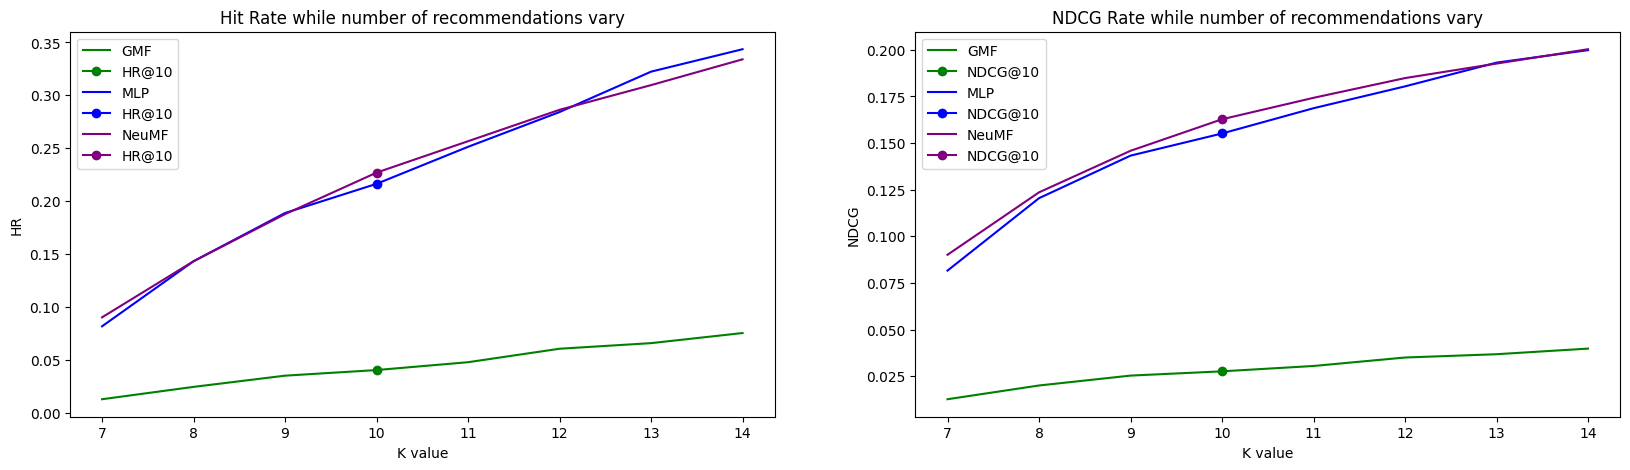

In [24]:
import matplotlib.pyplot as plt
fig, (hr_ax, ndcg_ax) = plt.subplots(1,2, figsize = (20, 5))
colors = ["green", "blue", "purple"]
for num, i in enumerate(HR.columns):
  hr_ax.plot(HR[i], label = i, color = colors[num])
  ndcg_ax.plot(NDCG[i], label = i, color = colors[num])
  hr_ax.plot([10],[HR[i][10]], marker = "o", color = colors[num], label = "HR@10")
  ndcg_ax.plot([10],[NDCG[i][10]], marker = "o", color = colors[num], label = "NDCG@10")


hr_ax.set_title("Hit Rate while number of recommendations vary")
ndcg_ax.set_title("NDCG Rate while number of recommendations vary")
hr_ax.set_ylabel("HR")
hr_ax.set_xlabel("K value")
ndcg_ax.set_ylabel("NDCG")
ndcg_ax.set_xlabel("K value")
hr_ax.legend()
ndcg_ax.legend()
plt.show()

# Task 3 - Metrics Evaluation while num factors vary

In [25]:
num_factors = [8, 16, 32, 64]
#do not change the order of HR and NDCG matrices
model_names = ["GMF Model", "MLP Model", "NeuMF model"]
mlp_models, gmf_models, nmf_models = {}, {}, {}

#I create a dict containing as the key the num_factor and as a value the relative model 
for num in num_factors:
    mlp_models[num] = torch.load(MODEL_PATH + "MLP{}.pt".format(num), map_location = device)
    gmf_models[num] = torch.load(MODEL_PATH + "GMF{}.pt".format(num), map_location = device)
    nmf_models[num] = torch.load(MODEL_PATH + "NeuMF{}.pt".format(num), map_location = device)

FileNotFoundError: [Errno 2] No such file or directory: './models/MLP8.pt'

In [ ]:
HR, NDCG = list([]), list([])

#for each num factor and for each model I compute the provided metrics on the test set
for num in tqdm(num_factors):
    hr_gmf, ndcg_gmf = metrics(gmf_models[num], test_loader, 10, device)
    hr_mlp, ndcg_mlp = metrics(mlp_models[num], test_loader, 10, device)
    hr_nmf, ndcg_nmf = metrics(nmf_models[num], test_loader, 10, device)
    HR.append([hr_gmf, hr_mlp, hr_nmf])
    NDCG.append([ndcg_gmf, ndcg_mlp, ndcg_nmf])

In [ ]:
#Here I transpose the matrices because I need to have on the same row the results of the metrics for the same model (in order to construct the bar plot)
HR = np.array(HR).T
NDCG = np.array(NDCG).T

In [ ]:
from matplotlib.container import BarContainer 
fig, (ax1, ax2) = plt.subplots(2, 1, layout='constrained', figsize = (10,12))
x = np.arange(HR.shape[1])
offset = -0.2
for i in range(len(HR)):
    rects1 = ax1.bar(x + offset, np.round(HR[i], 3), width=0.2, label = model_names[i])
    rects2 = ax2.bar(x + offset, np.round(NDCG[i], 3), width=0.2, label = model_names[i])
    ax1.bar_label(rects1, padding = 2)
    ax2.bar_label(rects2, padding = 2)
    offset += 0.2

ax1.set_ylim(min(HR.reshape(-1,1)) - 0.05, max(HR.reshape(-1,1)) + 0.05)
ax2.set_ylim(min(NDCG.reshape(-1,1)) - 0.05, max(NDCG.reshape(-1,1)) + 0.05)

ax1.set_xticks(x)
ax1.set_ylabel("HR")
ax1.set_xticklabels(num_factors)
ax1.set_xlabel("num factors")


ax2.set_xticks(x)
ax2.set_ylabel("NDCG")
ax2.set_xlabel("num factors")
ax2.set_xticklabels(num_factors)

ax1.set_title("Hit Rate")
ax2.set_title("Normalized Discounted Cumulative Gain")

ax1.legend()
ax2.legend()



## HyperParameter Tuning With RayTune
If there is a need for a more detailed description of how to use and configure the Hyper Parameter Tuning procedure we will provide them in the next version of the notebook.

### We first need to define a config dict that defines the search space of the hyperparameters

In [ ]:
config = {
    "lr": tune.choice([0.005, 0.015, 0.01, 0.001]),
    "batch_size": tune.choice([128, 256, 512]),
    "num_factors": tune.choice([8, 16, 32]),
    "epochs": tune.choice([15, 30, 40]),
    "out": True,
    "layers": tune.choice([[32, 16, 8], [64, 32, 8]]),
    "dropout": np.random.choice([0, 0.2, 0.5], size=(7, 20), p=[0.5, 0.3, 0.2])
}

### Initialize the scheduler and running the HT procedure
There is a paper related to the ASAH Scheduler at :https://arxiv.org/abs/1810.05934

In [ ]:
scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=40,
        grace_period=5,
        reduction_factor=2)

reporter = CLIReporter(
        metric_columns=["loss"]
)

### Train Function
We have to define a train function that takes as argument the config file.
This function will:
- Initialize NeuMF model with the specified config parameters (num factors, layers, dropout vector for the different layers)
- Initialize Train and validation dataloaders
- Train the model on the Train dataloader
- Evaluate the validation loss and report it to RayTune
- Save the best model


In [ ]:
# trains and save the model and returns the lists of train_loss and validation_loss
def train_NeuMF(config):
    # model = NeuMF_parametric_dropout(config['num_factors'], num_users, num_items, config['layers'], config['dropout'])
    model = NeuMF(
        config["num_factors"], num_users, num_items, config["layers"], config["dropout"]
    )

    train_loader, valid_loader, _, _ = data_loaders_from_data(
        PATH, batch_size=config["batch_size"]
    )

    model = model.to(device)

    loss_function = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])

    # train, evaluation
    best_valid_loss = math.inf
    train_loss, valid_loss = [], []

    for epoch in range(config["epochs"]):
        model.train()  # Enable dropout (if present).

        intermediate_train_loss = []
        for user, item, label in train_loader:
            user = user.to(device)
            item = item.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            prediction = model(user, item)
            loss = loss_function(prediction, label)
            loss.backward()
            optimizer.step()
            intermediate_train_loss.append(loss.cpu().detach().item())

        train_loss.append(np.mean(intermediate_train_loss))
        model.eval()

        intermediate_valid_loss = []
        for user, item, label in valid_loader:
            user = user.to(device)
            item = item.to(device)
            label = label.to(device)

            prediction = model(user, item)
            loss = loss_function(prediction, label)

            intermediate_valid_loss.append(loss.cpu().detach().item())

        valid_loss.append(np.mean(intermediate_valid_loss))
        if valid_loss[epoch] < best_valid_loss:
            best_valid_loss = valid_loss[epoch]
            if config["out"]:
                if not os.path.exists(MODEL_PATH):
                    os.mkdir(MODEL_PATH)
                torch.save(
                    model,
                    f"{MODEL_PATH}{model.__class__.__name__}{model.num_factors}.pt",
                )

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=valid_loss[epoch])

    losses = pd.DataFrame({"train loss": train_loss, "valid loss": valid_loss})
    losses.to_csv(f"{MODEL_PATH}{model.__class__.__name__}{model.num_factors}.csv")
    return train_loss, valid_loss


In [ ]:
result = tune.run(
    train_NeuMF,
    local_dir="./checkpoints/",
    resources_per_trial={"cpu": 4},
    config=config,
    num_samples=10,
    scheduler=scheduler,
    progress_reporter=reporter,
    checkpoint_at_end=False,
)

In [ ]:

best_trial = result.get_best_trial("loss", "min", "last")
best_checkpoint_dir = best_trial.checkpoint.dir_or_data
model_state, optimizer_state = torch.load(os.path.join(
    best_checkpoint_dir, "checkpoint"))

best_trained_model = NeuMF(best_trial.config["num_factors"], num_users, num_items, best_trial.config["layers"], best_trial.config['dropout']) 

best_trained_model.load_state_dict(model_state)
torch.save(best_trained_model, '{}{}{}_best_so_far.pt'.format(MODEL_PATH, best_trained_model.__class__.__name__, best_trained_model.factor_num))

best_trial.config

### Reporting the best configuration in our tests

In [ ]:
best_config = {
    "lr": 0.01,
    "batch_size": 256,
    "num_factors": 8,
    "epochs": 20,
    "out": True,
    "layers": (64, 16, 8),
    "dropout": (0, 0, 0, 0, 0, 0, 0.5),
}